## Project Description

In this project, we aim to calculate the following equation on multiple GPUs using PyTorch and find its lowest value on a grid where $i, j$ go up to 80, 60 respectively. Ultimately, we wish to compare SOM mapping time on a GPU and a CPU.

$$ \chi_{i, j}^2 = \sum_{k = 1}^{11} (G^k - W_{i, j}^k)$$

Therefore, for purposes of programming with PyTorch, $W$ is a single tensor with depth, height, width of `11, 60, 80` and $G$'s are a set of tensors with depth, height, width of `11, 1, 1`.

Author: Miladiouss (Milad Pourrahmani)

Email : mpourrah@uci.edu / miladiouss@gmail.com

Date  : May 3, 2019

## Imports and GPU Test

In [2]:
#-----------------------------------------------------------
# IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
#-----------------------------------------------------------
from time import time
import numpy as np
import math
from numba import vectorize, cuda

In [3]:
from datetime import datetime
timeFormat = '%a %b %d %Y at %H:%M:%S'
import socket
deviceName = socket.gethostname()
import getpass
userName = getpass.getuser()

t1 = datetime.now()
print(t1.strftime(timeFormat) + ' on ' + deviceName + ' by ' + userName)


# GPU Detection Tests
from torch.cuda import device_count
import torch
import gpustat

if False:
    print("""
    If pytorch raises "RuntimeError: cuda runtime error (30)" after suspension,
    run the following commands in linux terminal:

    sudo rmmod nvidia_uvm
    sudo rmmod nvidia
    sudo modprobe nvidia
    sudo modprobe nvidia_uvm
    
    Then restart Jupyter kernel
    """)

print('gpustat output:\n')
gpustat.print_gpustat()
print('\n\n')

numGPUs = torch.cuda.device_count()
print('=== Name of {} GPUs by PyTorch ===\n'.format(numGPUs))
for i in range(numGPUs):
    print('[{}]: {}'.format(i, torch.cuda.get_device_name(i)))
print('=================================')

torch.cuda.empty_cache()

Fri May 03 2019 at 02:06:06 on neuron by miladiouss
gpustat output:

neuron  Fri May  3 02:06:06 2019
[0] GeForce 940MX    | 47'C,   0 % |     0 /  2004 MB |
[1] TITAN V          | 37'C,  10 % |     0 / 12036 MB |



=== Name of 2 GPUs by PyTorch ===

[0]: TITAN V
[1]: GeForce 940MX


## PyTorch Implementation and Timing

In [90]:
for N in (10, 100, 1000, 10000, 100000, 1000000):
    _  = torch.manual_seed(42)
    vs = 11
#     N  = 100 # Suggestion for CPU/GPU: 1e4/1e6
    bs = 1000 # Suggestion for GPU: 1000
    printMod = ['t_tot', 'all'][1]
    #===================================================

    # Imports
    from time import time

    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader

    # Device managements
    deviceID = 0
    device = torch.device('cuda:{}'.format(deviceID) if torch.cuda.is_available() else 'cpu')
    if False:
        device = 'cpu'
        torch.set_num_threads = 1
    else:
        if printMod == 'all':
            print('device name        :  {}'.format(torch.cuda.get_device_name(deviceID)))
    if printMod == 'all':
        print('device             :  {}'.format(device))

    # Dataset 
    class RandomDataset(Dataset):

        def __init__(self, size):
            self.len = size

        def __getitem__(self, index):
            return torch.randn((vs, 1, 1))

        def __len__(self):
            return self.len

    valset    = RandomDataset(N)
    valLoader = DataLoader(valset, batch_size=bs, pin_memory=False)

    # Main model
    class Model(nn.Module):
        def __init__(self, W_depth = vs, W_height = 80, W_width = 60, feed = None, bs = bs, device = device):
            super(Model, self).__init__()
            self.W = torch.rand((W_depth, W_height, W_width))
            if feed is not None:
                self.W = feed
            self.W        = self.W.to(device)
            self.localGs  = torch.randn((bs, vs, 1, 1))
            self.localGs  = self.localGs.to(device)


        def chiFunc(self, Gs):
            '''Works on batches'''
            output = torch.add(self.W, -Gs)**2
            output = output.sum(1)
            output = torch.min(output.flatten(1), 1)
            # Returns lowest values and corresponding locations
            return output


        def forward(self, Gs, local = False):
            if Gs is None:
                Gs = self.localGs
            return self.chiFunc(Gs)

    # Place model on device
    model = Model()
    if True and device != 'cpu':
        model = torch.nn.DataParallel(model, device_ids=[deviceID])
    else:
        model = model.to(device)

    # Timing setup
    t_calc  = 0
    t_trans = 0
    t_tot   = 0

    t1_tot = time()

    # Main calculations

    # Mock data is created on GPU
    if True:
        if printMod == 'all':
            print("Data Management    :  Generated  on device")
        for i in range(N//bs):
            t1_calc = time()
            output = model(None)
            t2_calc = time()
            t_calc += t2_calc - t1_calc

    # Mock data is transfered to GPU
    else:
        if printMod == 'all':
            print("Data Management    :  Transfered to device")
        for i, Gbatch in enumerate(valLoader):
            t1_trans = time()
            Gbatch = Gbatch.to(device)
            t2_trans = time()
            t_trans += t2_trans - t1_trans

            t1_calc = time()
            output = model(Gbatch)
            t2_calc = time()
            t_calc += t2_calc - t1_calc

    t2_tot = time()
    t_tot = t2_tot - t1_tot

    # Reports
    if printMod == 'all':
        print('Load Time          : {: e} s per {:.0e}'.format(t_tot - t_trans - t_calc, N))
        print('Transfer Time      : {: e} s per {:.0e}'.format(t_trans, N))
        print('Calculation Time   : {: e} s per {:.0e}'.format(t_calc, N))
        print('Total       Time   : {: e} s per {:.0e}'.format(t_tot, N))
        print("=====================================================================================")
    if printMod == 't_tot':
        print(t_tot, end=', ')

device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  5.674362e-05 s per 1e+01
Transfer Time      :  0.000000e+00 s per 1e+01
Calculation Time   :  0.000000e+00 s per 1e+01
Total       Time   :  5.674362e-05 s per 1e+01
Shooby's CPU Time  :  9.000000e+00 s per 1e+04
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  6.365776e-05 s per 1e+02
Transfer Time      :  0.000000e+00 s per 1e+02
Calculation Time   :  0.000000e+00 s per 1e+02
Total       Time   :  6.365776e-05 s per 1e+02
Shooby's CPU Time  :  9.000000e+00 s per 1e+04
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  9.822845e-05 s per 1e+03
Transfer Time      :  0.000000e+00 s per 1e+03
Calculation Time   :  4.632473e-04 s per 1e+03
Total       Time   :  5.614758e-04 s per 1e+03
Shooby's CPU Time  :  9.000000e+00 s

#### 1. GPU Time Records (Without Data Transfer)

```
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  1.814365e-03 s per 1e+01
Transfer Time      :  0.000000e+00 s per 1e+01
Calculation Time   :  0.000000e+00 s per 1e+01
Total       Time   :  1.814365e-03 s per 1e+01
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  4.076958e-05 s per 1e+02
Transfer Time      :  0.000000e+00 s per 1e+02
Calculation Time   :  0.000000e+00 s per 1e+02
Total       Time   :  4.076958e-05 s per 1e+02
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  5.221367e-05 s per 1e+03
Transfer Time      :  0.000000e+00 s per 1e+03
Calculation Time   :  4.060268e-04 s per 1e+03
Total       Time   :  4.582405e-04 s per 1e+03
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  5.388260e-05 s per 1e+04
Transfer Time      :  0.000000e+00 s per 1e+04
Calculation Time   :  1.125097e-03 s per 1e+04
Total       Time   :  1.178980e-03 s per 1e+04
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  1.611710e-04 s per 1e+05
Transfer Time      :  0.000000e+00 s per 1e+05
Calculation Time   :  1.376677e-02 s per 1e+05
Total       Time   :  1.392794e-02 s per 1e+05
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Generated  on device
Load Time          :  3.225565e-03 s per 1e+06
Transfer Time      :  0.000000e+00 s per 1e+06
Calculation Time   :  1.292620e+00 s per 1e+06
Total       Time   :  1.295846e+00 s per 1e+06
=====================================================================================
```

In [4]:
run1 = 3.5762786865234375e-06, 4.291534423828125e-06, 0.00026679039001464844, 0.0015590190887451172, 0.011265039443969727, 1.2953987121582031, 15.942537784576416, 
run2 = 2.86102294921875e-06, 2.6226043701171875e-06, 0.00026988983154296875, 0.001641988754272461, 0.008538007736206055, 1.2956111431121826, 15.947063446044922, 
run3 = 3.0994415283203125e-06, 3.5762786865234375e-06, 0.00048613548278808594, 0.001975536346435547, 0.01061248779296875, 1.2957241535186768, 15.945496082305908, 
Ns   = np.array([10, 100, 1000, 10000, 100000, 1000000, 10000000])

run1 = np.array(run1)
run2 = np.array(run2)
run3 = np.array(run3)

run123I = np.mean((run1, run2, run3), 0)

#### 2. GPU Time Records (With Data Transfer)

```
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Transfered to device
Load Time          :  3.957748e-04 s per 1e+01
Transfer Time      :  6.866455e-05 s per 1e+01
Calculation Time   :  4.634857e-04 s per 1e+01
Total       Time   :  9.279251e-04 s per 1e+01
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Transfered to device
Load Time          :  7.259846e-04 s per 1e+02
Transfer Time      :  4.839897e-05 s per 1e+02
Calculation Time   :  1.916885e-04 s per 1e+02
Total       Time   :  9.660721e-04 s per 1e+02
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Transfered to device
Load Time          :  5.710125e-03 s per 1e+03
Transfer Time      :  2.176762e-04 s per 1e+03
Calculation Time   :  4.482269e-04 s per 1e+03
Total       Time   :  6.376028e-03 s per 1e+03
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Transfered to device
Load Time          :  4.211116e-02 s per 1e+04
Transfer Time      :  1.444340e-03 s per 1e+04
Calculation Time   :  4.163265e-03 s per 1e+04
Total       Time   :  4.771876e-02 s per 1e+04
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Transfered to device
Load Time          :  3.824205e-01 s per 1e+05
Transfer Time      :  1.075053e-02 s per 1e+05
Calculation Time   :  2.390003e-02 s per 1e+05
Total       Time   :  4.170711e-01 s per 1e+05
=====================================================================================
device name        :  TITAN V
device             :  cuda:0
Data Management    :  Transfered to device
Load Time          :  5.193329e+00 s per 1e+06
Transfer Time      :  1.403193e-01 s per 1e+06
Calculation Time   :  3.657453e-01 s per 1e+06
Total       Time   :  5.699394e+00 s per 1e+06
=====================================================================================
```

In [5]:
run1 = 0.00046634674072265625, 0.0010683536529541016, 0.0068149566650390625, 0.056452035903930664, 0.45601558685302734, 5.35297703742981, 50.70260453224182, 
run2 = 0.0008776187896728516, 0.0008144378662109375, 0.006388425827026367, 0.05249810218811035, 0.5033338069915771, 6.025055646896362, 51.,
run3 = 0.0010247230529785156, 0.0011801719665527344, 0.012906789779663086, 0.04403996467590332, 0.5602531433105469, 6.38318657875061, 51.,

run1 = np.array(run1)
run2 = np.array(run2)
run3 = np.array(run3)

run123II = np.mean((run1, run2, run3), 0)

#### 3. CPU Time Records

```
=====================================================================================
device             :  cpu
Data Management    :  Transfered to device
Load Time          :  4.427433e-04 s per 1e+01
Transfer Time      :  5.245209e-06 s per 1e+01
Calculation Time   :  1.560926e-03 s per 1e+01
Total       Time   :  2.008915e-03 s per 1e+01
=====================================================================================
device             :  cpu
Data Management    :  Transfered to device
Load Time          :  8.444786e-04 s per 1e+02
Transfer Time      :  9.059906e-06 s per 1e+02
Calculation Time   :  1.104832e-02 s per 1e+02
Total       Time   :  1.190186e-02 s per 1e+02
=====================================================================================
device             :  cpu
Data Management    :  Transfered to device
Load Time          :  6.634235e-03 s per 1e+03
Transfer Time      :  2.670288e-05 s per 1e+03
Calculation Time   :  9.969068e-02 s per 1e+03
Total       Time   :  1.063516e-01 s per 1e+03
=====================================================================================
device             :  cpu
Data Management    :  Transfered to device
Load Time          :  6.788874e-02 s per 1e+04
Transfer Time      :  2.219677e-04 s per 1e+04
Calculation Time   :  1.463918e+00 s per 1e+04
Total       Time   :  1.532029e+00 s per 1e+04
=====================================================================================
device             :  cpu
Data Management    :  Transfered to device
Load Time          :  5.639410e-01 s per 1e+05
Transfer Time      :  1.487732e-03 s per 1e+05
Calculation Time   :  1.349072e+01 s per 1e+05
Total       Time   :  1.405615e+01 s per 1e+05
=====================================================================================
device             :  cpu
Data Management    :  Transfered to device
Load Time          :  5.423350e+00 s per 1e+06
Transfer Time      :  1.540160e-02 s per 1e+06
Calculation Time   :  1.374256e+02 s per 1e+06
Total       Time   :  1.428644e+02 s per 1e+06
=====================================================================================```

In [6]:
run1 = 0.0007658004760742188, 0.006584882736206055, 0.11615705490112305, 1.330733299255371, 12.783903360366821, 142.0729537010193, 1500 # 1500 has been extrapolated
run2 = run1
run3 = run1
Ns   = np.array([10, 100, 1000, 10000, 100000, 1000000, 10000000])

run1 = np.array(run1)
run2 = np.array(run2)
run3 = np.array(run3)

run123III = np.mean((run1, run2, run3), 0)

### Plotting

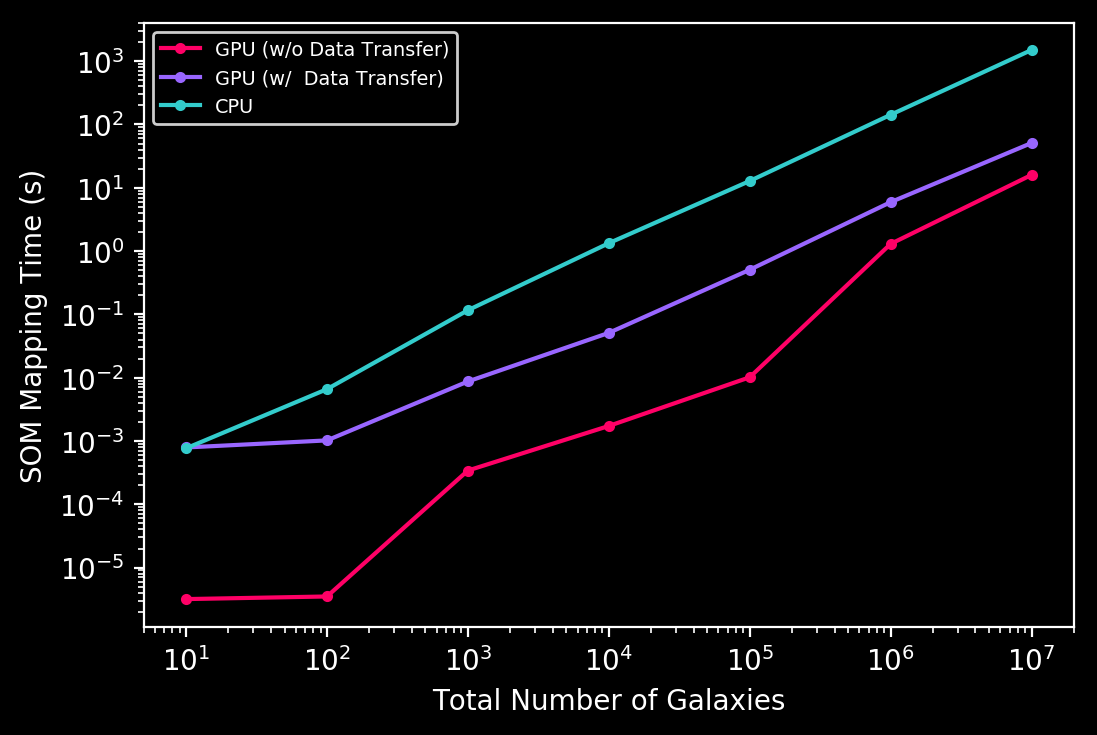

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
if True:
    _ = plt.style.use('dark_background')
fig, axs = plt.subplots(1, 1)
ax11 = axs

_ = ax11.loglog(Ns, run123I, label = "GPU (w/o Data Transfer)", marker = '.', color = '#ff0066')
_ = ax11.loglog(Ns, run123II, label = "GPU (w/  Data Transfer)", marker = '.', color = '#9966ff')
_ = ax11.loglog(Ns, run123III, label = "CPU", marker = '.', color = '#33cccc')

_ = fig.set_dpi(200)
_ = ax11.set_xlabel('Total Number of Galaxies')
_ = ax11.set_ylabel('SOM Mapping Time (s)')
legend = ax11.legend(loc='upper left', shadow=True, fontsize='x-small')



## Proof of Concept
This section was developed before creating a PyTorch model, even though it is placed last.

### Data Initialization

In [7]:
quickTestDict = {'Number of Samples' : 2, 'Vector Size' : 3, 'Grid Height' : 2, 'Grid Width' : 2, 'dtype' : np.int16, 'dictName' : 'quickTest'}
longTestDict  = {'Number of Samples' : 10, 'Vector Size' : 11, 'Grid Height' : 100, 'Grid Width' : 100, 'dtype' : np.float32, 'dictName' : 'longTest'}
paramDict = [quickTestDict, longTestDict][0]

N       = paramDict['Number of Samples']
W_shape = (paramDict['Vector Size'], paramDict['Grid Height'], paramDict['Grid Width'])
G_shape = (paramDict['Vector Size'], 1, 1)
dtype   = np.float32
rs      = np.random.RandomState(seed=42)
W       = rs.randint(0, 10, W_shape).astype(dtype)
Gs      = rs.randint(0, 10, (N, *G_shape)).astype(dtype)

# Convert to torch tensor
W       = torch.Tensor(W)
Gs      = torch.Tensor(Gs)
print('W  Shape: {}'.format(W.shape))
print('Gs Shape: {}'.format(Gs.shape))

W  Shape: torch.Size([3, 2, 2])
Gs Shape: torch.Size([2, 3, 1, 1])


### Method I

In [8]:
if paramDict['dictName'] == 'quickTest':
    for i, G in enumerate(Gs):
        G_grid   = torch.ones_like(W)
        G_grid   = torch.mul(G, G_grid)
        chi_grid = torch.sum((W - G_grid)**2, 0)
        chi_min  = torch.min(chi_grid)
        print("Least Chi-Squared for G[{}]: {:.1e}".format(i, chi_min))

Least Chi-Squared for G[0]: 4.0e+00
Least Chi-Squared for G[1]: 2.5e+01


### Method II (Using PyTorch Model)

In [11]:
print("Model output (min chi for each batch and the corresponding location):")
model = Model(feed=W)
model(Gs.to(device))

Model output (min chi for each batch and the corresponding location):


(tensor([ 4., 25.], device='cuda:0'), tensor([2, 3], device='cuda:0'))

### Method III
Compare the output of the following with the Method II output.

In [12]:
if paramDict['dictName'] == 'quickTest':
    print('\nW = ')
    print(W)
    print('\nGs = ')
    print(Gs)

    print("\n(W - G)**2 for each G:")
    output = torch.add(W, -Gs)**2
    output
    
    print("\nSum of (W - G)**2 for each G:")
    output.sum(1)


W = 
tensor([[[6., 3.],
         [7., 4.]],

        [[6., 9.],
         [2., 6.]],

        [[7., 4.],
         [3., 7.]]])

Gs = 
tensor([[[[7.]],

         [[2.]],

         [[5.]]],


        [[[4.]],

         [[1.]],

         [[7.]]]])

(W - G)**2 for each G:


tensor([[[[ 1., 16.],
          [ 0.,  9.]],

         [[16., 49.],
          [ 0., 16.]],

         [[ 4.,  1.],
          [ 4.,  4.]]],


        [[[ 4.,  1.],
          [ 9.,  0.]],

         [[25., 64.],
          [ 1., 25.]],

         [[ 0.,  9.],
          [16.,  0.]]]])


Sum of (W - G)**2 for each G:


tensor([[[21., 66.],
         [ 4., 29.]],

        [[29., 74.],
         [26., 25.]]])

In [13]:
# add works on batches too
if False:
    torch.add(W, -Gs)
    torch.cat([torch.add(W, -Gs[0]), torch.add(W, -Gs[1])])

## Recycle

In [ ]:
# Recycled code from torch Model class

# self.G_grid   = torch.ones_like(self.W)

#     def ChiFunc1(self, G):
#         G_grid   = self.G_grid
#         G_grid   = torch.mul(G, self.G_grid)
#         Chi_grid = torch.sum((self.W - G_grid)**2, 0)
#         Chi_min  = torch.min(Chi_grid)
#         return Chi_min
    
#     def ChiFunc2(self, G):
#         output = torch.add(self.W, -G)**2
#         output = torch.sum(output, 0)
#         output = torch.min(output)
#         return output


# Recycled code from Proof of Work

# if True:
#     print('\nW = ')
#     print(W)
#     print('\nG = ')
#     print(G)
#     print('\nW[:, 0, 0] = ', W[:, 0, 0].numpy())
#     print('\nG[:, 0, 0] = ', G[:, 0, 0].numpy())
#     print('\n(G00 - W00)**2 = ', (W[:, 0, 0] - G[:, 0, 0])**2)
#     print('\nsum00 = ', torch.sum((W[:, 0, 0] - G[:, 0, 0])**2))
#     print('\n(G00 - W01)**2 = ', (W[:, 0, 1] - G[:, 0, 0])**2)
#     print('\nsum01 = ', torch.sum((W[:, 0, 1] - G[:, 0, 0])**2))
#     print('\n(G00 - W10)**2 = ', (W[:, 1, 0] - G[:, 0, 0])**2)
#     print('\nsum10 = ', torch.sum((W[:, 1, 0] - G[:, 0, 0])**2))
#     print('\n(G00 - W11)**2 = ', (W[:, 1, 1] - G[:, 0, 0])**2)
#     print('\nsum11 = ', torch.sum((W[:, 1, 1] - G[:, 0, 0])**2))
